*****Neural style Transfer*****

In [0]:
import os
import sys
import scipy.io
import scipy.misc
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from PIL import Image

import numpy as np
import tensorflow as tf

%matplotlib inline

In [0]:
from nst_utils import *

downloading pretrained model

In [204]:
!wget --output-document=imagenet-vgg-verydeep-19.mat 'https://storage.googleapis.com/marketing-files/colab-notebooks/style-transfer/imagenet-vgg-verydeep-19.mat'

--2019-04-06 23:37:57--  https://storage.googleapis.com/marketing-files/colab-notebooks/style-transfer/imagenet-vgg-verydeep-19.mat
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.141.128, 2607:f8b0:400c:c06::80
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.141.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 534904783 (510M) [application/octet-stream]
Saving to: ‘imagenet-vgg-verydeep-19.mat’

imagenet-vgg-veryde 100%[===================>] 510.12M   167MB/s    in 3.1s    

2019-04-06 23:38:01 (167 MB/s) - ‘imagenet-vgg-verydeep-19.mat’ saved [534904783/534904783]



In [205]:
model = load_vgg_model("imagenet-vgg-verydeep-19.mat")
print(model)

{'input': <tf.Variable 'Variable_2:0' shape=(1, 487, 626, 3) dtype=float32_ref>, 'conv1_1': <tf.Tensor 'Relu_32:0' shape=(1, 487, 626, 64) dtype=float32>, 'conv1_2': <tf.Tensor 'Relu_33:0' shape=(1, 487, 626, 64) dtype=float32>, 'avgpool1': <tf.Tensor 'AvgPool_10:0' shape=(1, 244, 313, 64) dtype=float32>, 'conv2_1': <tf.Tensor 'Relu_34:0' shape=(1, 244, 313, 128) dtype=float32>, 'conv2_2': <tf.Tensor 'Relu_35:0' shape=(1, 244, 313, 128) dtype=float32>, 'avgpool2': <tf.Tensor 'AvgPool_11:0' shape=(1, 122, 157, 128) dtype=float32>, 'conv3_1': <tf.Tensor 'Relu_36:0' shape=(1, 122, 157, 256) dtype=float32>, 'conv3_2': <tf.Tensor 'Relu_37:0' shape=(1, 122, 157, 256) dtype=float32>, 'conv3_3': <tf.Tensor 'Relu_38:0' shape=(1, 122, 157, 256) dtype=float32>, 'conv3_4': <tf.Tensor 'Relu_39:0' shape=(1, 122, 157, 256) dtype=float32>, 'avgpool3': <tf.Tensor 'AvgPool_12:0' shape=(1, 61, 79, 256) dtype=float32>, 'conv4_1': <tf.Tensor 'Relu_40:0' shape=(1, 61, 79, 512) dtype=float32>, 'conv4_2': <tf

In [201]:
from google.colab import files

content_img = files.upload()

KeyboardInterrupt: ignored

In [77]:
import os

CONTENT_IMAGE_FN = list(content_img)[0]
CONTENT_IMAGE_FN_temp = CONTENT_IMAGE_FN.strip().replace(" ", "_")

if CONTENT_IMAGE_FN != CONTENT_IMAGE_FN_temp:
  os.rename(CONTENT_IMAGE_FN, CONTENT_IMAGE_FN_temp)
  CONTENT_IMAGE_FN = CONTENT_IMAGE_FN_temp
  
print("Content image filename :", CONTENT_IMAGE_FN)

Content image filename : n.jpeg


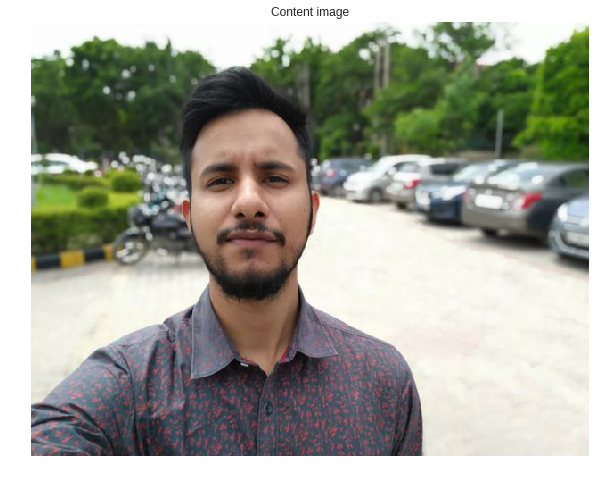

In [78]:
%matplotlib inline
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10, 10))
img = plt.imread(CONTENT_IMAGE_FN)
plt.axis('off')
plt.title('Content image')
plt.imshow(img)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  """Entry point for launching an IPython kernel.


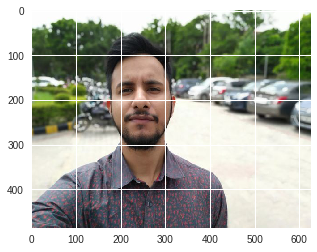

In [79]:
content_image = scipy.misc.imread(CONTENT_IMAGE_FN)
imshow(content_image)

In [161]:
content_image= scipy.misc.imresize(content_image,(487,626))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  """Entry point for launching an IPython kernel.


ValueError: ignored

In [81]:
content_image.shape

(487, 626, 3)

#### mask image

In [137]:
mask_img = files.upload()

Saving abc.jpg to abc.jpg


In [138]:
import os

MASK_IMAGE_FN = list(mask_img)[0]
MASK_IMAGE_FN_temp = MASK_IMAGE_FN.strip().replace(" ", "_")

if MASK_IMAGE_FN != MASK_IMAGE_FN_temp:
  os.rename(MASK_IMAGE_FN, MASK_IMAGE_FN_temp)
  MASK_IMAGE_FN = MASK_IMAGE_FN_temp
  
print("Content image filename :", MASK_IMAGE_FN)

Content image filename : abc.jpg


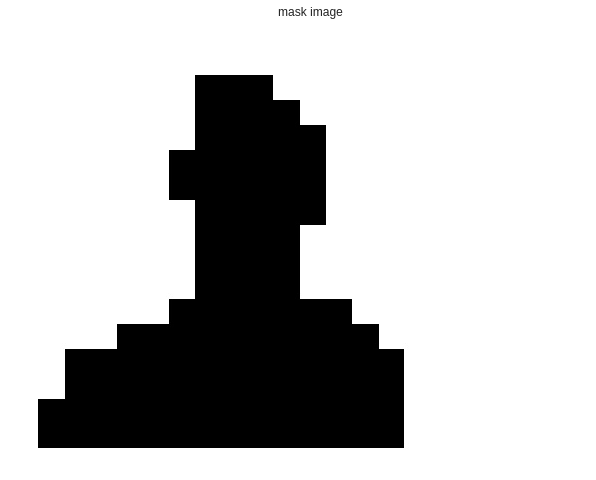

In [139]:
%matplotlib inline
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10, 10))
img = plt.imread(MASK_IMAGE_FN)
plt.axis('off')
plt.title('mask image')
plt.imshow(img)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  This is separate from the ipykernel package so we can avoid doing imports until


ValueError: ignored

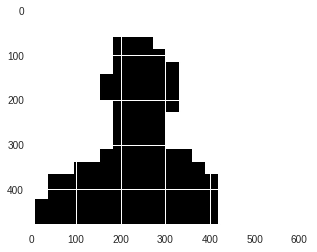

In [160]:
mask_image = scipy.misc.imread(MASK_IMAGE_FN)
imshow(mask_image)
content_image= scipy.misc.imresize(content_image,(487,626))


In [0]:

def compute_content_cost(a_C, a_G):
    
    m, n_H, n_W, n_C = a_G.get_shape().as_list()
    a_C_unrolled = tf.reshape(a_C,[-1])
    a_G_unrolled = tf.reshape(a_G,[-1])
    J_content = tf.reduce_sum((a_C_unrolled-a_G_unrolled)**2)/(4*n_H*n_W*n_C)
        
    return J_content

In [84]:
style_img = files.upload()

Saving www.jpeg to www.jpeg


In [85]:
STYLE_IMAGE_FN = list(style_img)[0]
STYLE_IMAGE_FN_temp = STYLE_IMAGE_FN.strip().replace(" ", "_")

if STYLE_IMAGE_FN != STYLE_IMAGE_FN_temp:
  os.rename(STYLE_IMAGE_FN, STYLE_IMAGE_FN_temp)
  STYLE_IMAGE_FN = STYLE_IMAGE_FN_temp
  
print("Style image filename :", STYLE_IMAGE_FN)

Style image filename : www.jpeg


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  """Entry point for launching an IPython kernel.


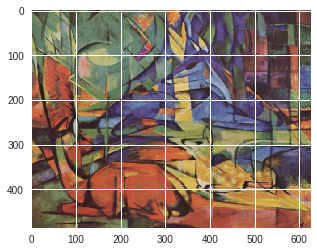

In [159]:
style_image = scipy.misc.imread(STYLE_IMAGE_FN)
imshow(style_image)

In [87]:
style_image= scipy.misc.imresize(style_image,(487,626))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  """Entry point for launching an IPython kernel.


In [88]:
style_image.shape

(487, 626, 3)

In [0]:


def gram_matrix(A):
   
    GA =tf.matmul(A,tf.transpose(A))
    
    return GA

In [0]:


def compute_layer_style_cost(a_S, a_G):
  
    #print(a_G.shape)
   
    m, n_H, n_W, n_C = a_G.get_shape().as_list()
    
    a_S = tf.reshape(a_S, [n_H*n_W, n_C])
    a_G = tf.reshape(a_G, [n_H*n_W, n_C])
    
    

    GS = gram_matrix(tf.transpose(a_S))
    GG = gram_matrix(tf.transpose(a_G))


    J_style_layer = tf.reduce_sum((GS - GG)**2) / (4 * n_C**2 * (n_W * n_H)**2)
    
    return J_style_layer

In [0]:
STYLE_LAYERS = [
    ('conv3_1', 0.2)]

In [0]:
STYLE_LAYERS_BACK = [
    ('conv1_1', 0.5),
    ('conv2_1', 0.5)]

In [0]:
def compute_style_cost_back(model,STYLE_LAYERS_BACK):
    
    

    J_back = 0

    for layer_name, coeff in STYLE_LAYERS_BACK:

        out = model[layer_name]

        
        a_S = sess.run(out)

        a_G = out #elementwise
        
        
        J_back_style_layer = compute_layer_style_cost(a_S, a_G)

       
        J_back += coeff * J_back_style_layer

    return J_back

In [0]:
def compute_style_cost(model, STYLE_LAYERS):
    
    

    J_style = 0

    for layer_name, coeff in STYLE_LAYERS:

        out = model[layer_name]

        
        a_S = sess.run(out)

        a_G = out
        
        
        J_style_layer = compute_layer_style_cost(a_S, a_G)

       
        J_style += coeff * J_style_layer

    return J_style

In [0]:

def total_cost(J_content, J_style, J_back, alpha = 10, beta = 40, gamma = 25):
    
   
    J = alpha*J_content+beta*J_style+gamma*J_back
  
    
    return J

In [148]:

tf.reset_default_graph()

sess = tf.InteractiveSession()

/usr/local/lib/python3.6/dist-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


In [0]:
content_image = reshape_and_normalize_image(content_image)

In [162]:
content_image.shape

(1, 487, 626, 3)

In [0]:
mask_image = reshape_and_normalize_image(mask_image)

In [165]:
mask_image.shape

(1, 487, 626, 3)

In [166]:
style_image = reshape_and_normalize_image(style_image)
print(style_image.shape)

(1, 487, 626, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


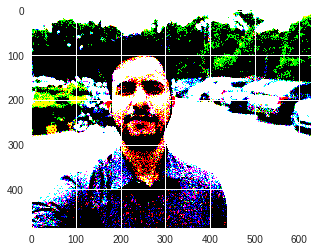

In [167]:
generated_image = generate_noise_image(content_image)
imshow(generated_image[0])

In [0]:
generated_image = (content_image)

In [0]:
model = load_vgg_model("imagenet-vgg-verydeep-19.mat")

In [0]:
  
sess.run(model['input'].assign(content_image))


out = model['conv5_3']


a_C = sess.run(out)

a_G = out


J_content = compute_content_cost(a_C, a_G)

In [0]:
sess.run(model['input'].assign(style_image))


J_style = compute_style_cost(model, STYLE_LAYERS)

In [0]:
sess.run(model['input'].assign(style_image))
J_back = compute_style_cost_back(model, STYLE_LAYERS_BACK)

In [0]:
J = total_cost(J_content, J_style, J_back, alpha=5, beta=20, gamma=25)

In [0]:

optimizer = tf.train.AdamOptimizer(2.0)

train_step = optimizer.minimize(J)

In [0]:
def model_nn(sess, input_image, num_iterations = 250):
        
    sess.run(tf.global_variables_initializer())
    
    sess.run(model['input'].assign(input_image))
    
    for i in range(num_iterations):
    
        
        _=sess.run(train_step)
       
        generated_image = sess.run(model['input'])
        
        if i%20 == 0:
            Jt, Jc, Js, Jb = sess.run([J, J_content, J_style, J_back])
            print("Iteration " + str(i) + " :")
            print("total cost = " + str(Jt))
            print("content cost = " + str(Jc))
            print("style cost = " + str(Js))
            print("background cost = " + str(Jb))
            
            
            save_image(str(i) + ".jpg", generated_image)
    
    
    save_image('generated_image.jpg', generated_image)
    
    return generated_image

In [176]:
model_nn(sess, generated_image)

Iteration 0 :
total cost = 95757770.0
content cost = 0.56255496
style cost = 893391.94
background cost = 3115597.2
Iteration 20 :
total cost = 21491674.0
content cost = 4.2124243
style cost = 140804.34
background cost = 747022.6
Iteration 40 :
total cost = 8603036.0
content cost = 4.9793725
style cost = 47676.71
background cost = 305979.06
Iteration 60 :
total cost = 4347872.0
content cost = 5.2629128
style cost = 24259.197
background cost = 154506.48
Iteration 80 :
total cost = 2527024.8
content cost = 5.5322556
style cost = 15666.375
background cost = 88546.78
Iteration 100 :
total cost = 1617986.2
content cost = 5.738353
style cost = 11152.663
background cost = 55796.17
Iteration 120 :
total cost = 1119998.8
content cost = 5.8918705
style cost = 8387.701
background cost = 38088.61
Iteration 140 :
total cost = 821621.1
content cost = 6.0111117
style cost = 6582.6104
background cost = 27597.555
Iteration 160 :
total cost = 628236.25
content cost = 6.1098733
style cost = 5342.928
backg

array([[[[104.491325 , 120.937805 , 122.56104  ],
         [ 42.254982 ,  31.499043 ,  26.562893 ],
         [ 71.1103   ,  52.91645  ,  39.30327  ],
         ...,
         [  0.2605451,  24.920885 ,  15.566574 ],
         [  9.665938 ,  34.363926 ,  11.9426775],
         [ 26.498457 ,  36.70513  , -27.503794 ]],

        [[ 40.813957 ,  16.463892 ,  26.438557 ],
         [ 41.403904 ,  43.370506 ,  52.111954 ],
         [ 54.37818  ,  44.879036 ,  53.89138  ],
         ...,
         [ 32.77292  ,  29.003702 ,  55.65868  ],
         [ 13.426852 ,  31.100908 ,  37.63702  ],
         [ -9.985767 ,  20.901386 ,  -1.0257189]],

        [[ 12.662677 ,  47.610004 ,  34.593063 ],
         [ 40.44971  ,  51.23054  ,  52.3084   ],
         [ 44.422497 ,  55.07093  ,  41.879044 ],
         ...,
         [ 38.94074  ,  42.62565  ,  59.493145 ],
         [ 26.687449 ,  36.911022 ,  49.6173   ],
         [-17.7826   ,  17.567791 ,  21.546621 ]],

        ...,

        [[-14.661355 , -21.610247 ,   

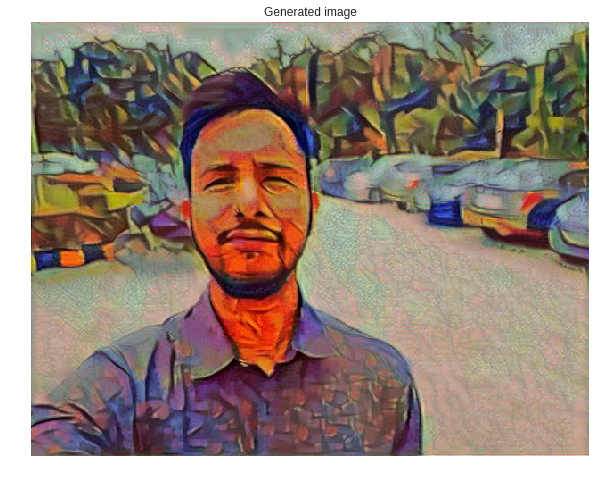

In [112]:

fig = plt.figure(figsize=(10, 10))
img = plt.imread("generated_image.jpg")
plt.axis('off')
plt.title('Generated image')
plt.imshow(img)

# New Section

In [0]:
def load_mask(mask, shape):
    mask = mask # Grayscale mask load
    width, height, _ = shape
    mask = imresize(mask, (width, height), interp='bicubic').astype('float32')

    # Perform binarization of mask
    mask[mask <= 127] = 0
    mask[mask > 128] = 255

    max = np.amax(mask)
    mask /= max

    return mask

In [0]:
# util function to apply mask to generated image
def mask_content(content, generated, mask):
    width, height, channels = generated.shape

    for i in range(width):
        for j in range(height):
            if mask[i, j] == 0.:
                generated[i, j, :] = content[i, j, :]

    return generated

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  if __name__ == '__main__':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: `imresize` is deprecated!

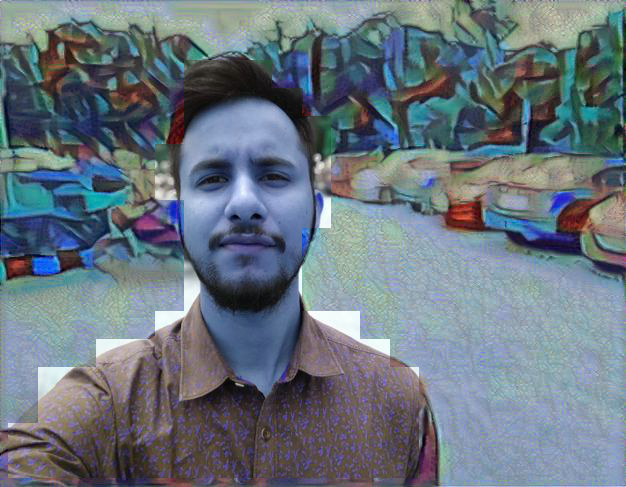

In [183]:

generated_image = imread("generated_image.jpg")
img_width, img_height, channels = generated_image.shape

content_image = imread("n.jpeg")
content_image = imresize(content_image, (img_width, img_height), interp='bicubic')


content_mask = imread("abc.jpg",mode="L")
mask = load_mask(content_mask, generated_image.shape)

img = mask_content(content_image, generated_image, mask)
cv2_imshow(img)

#imsave(image_path, img)

#print("Image saved at path : %s" % image_path)

In [184]:
img.shape

(487, 626, 3)

In [185]:
mask_updated = reshape_and_normalize_image(img)
print(mask_updated.shape)

(1, 487, 626, 3)


In [0]:
def model_nn(sess, input_image, num_iterations = 100):
        
    sess.run(tf.global_variables_initializer())
    
    sess.run(model['input'].assign(input_image))
    
    for i in range(num_iterations):
    
        
        _=sess.run(train_step)
       
        generated_image = sess.run(model['input'])
        
        if i%20 == 0:
            Jt, Jc, Js, Jb = sess.run([J, J_content, J_style, J_back])
            print("Iteration " + str(i) + " :")
            print("total cost = " + str(Jt))
            print("content cost = " + str(Jc))
            print("style cost = " + str(Js))
            print("background cost = " + str(Jb))
            
            
            save_image(str(i) + ".jpg", generated_image)
    
    
    save_image('generated_image.jpg', generated_image)
    
    return generated_image

In [191]:
model_nn(sess, mask_updated)

Iteration 0 :
total cost = 8657609.0
content cost = 3.4613333
style cost = 92230.375
background cost = 272519.38
Iteration 20 :
total cost = 1213732.0
content cost = 4.530265
style cost = 12613.2295
background cost = 38457.793
Iteration 40 :
total cost = 511359.94
content cost = 4.971127
style cost = 6038.7
background cost = 15622.443
Iteration 60 :
total cost = 254437.75
content cost = 5.1610394
style cost = 3562.8235
background cost = 7326.2188
Iteration 80 :
total cost = 161151.34
content cost = 5.3032136
style cost = 2505.6807
background cost = 4440.4487


array([[[[ 79.680336  ,  87.93167   ,  52.013527  ],
         [ 52.291443  ,  46.28402   ,  33.611446  ],
         [ 32.670128  ,  37.356834  ,   2.1679072 ],
         ...,
         [ -0.27827072,  -1.4759303 , -51.127167  ],
         [  8.367023  ,  50.40823   , -52.249134  ],
         [ -1.5989769 ,  45.44582   , -48.561348  ]],

        [[ 21.4805    ,  33.552673  ,   5.011267  ],
         [ 28.610497  ,  26.376081  ,  21.01633   ],
         [ 36.105335  ,  37.574238  ,  25.952677  ],
         ...,
         [ 16.101807  , -41.117672  ,   4.724186  ],
         [ 10.893051  ,  22.793688  , -14.967167  ],
         [ -0.5558157 ,  21.738432  , -95.53377   ]],

        [[  7.5851784 ,  30.295229  ,  11.176604  ],
         [ 25.437977  ,  17.162485  ,  25.15255   ],
         [ 37.650738  ,  24.569225  ,  34.156982  ],
         ...,
         [ 23.71735   ,  27.2217    ,  26.295128  ],
         [  3.0413637 , -10.052801  ,  42.387512  ],
         [  6.515493  ,   2.73635   ,  19.779327  ]],

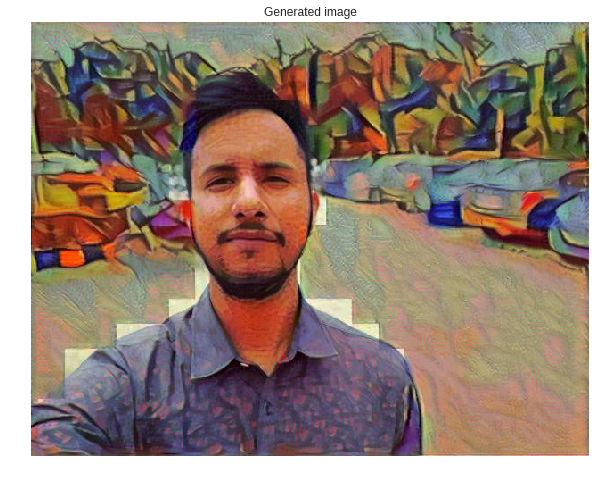

In [192]:

fig = plt.figure(figsize=(10, 10))
img = plt.imread("generated_image.jpg")
plt.axis('off')
plt.title('Generated image')
plt.imshow(img)

In [0]:
from google.colab.patches import cv2_imshow

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:85: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:88: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:89: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: DeprecationWarning: `toimage` is deprecated!
`toimage` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use Pillow's ``Image.fromarray`` directly instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: DeprecationWarning: `fromimage` is deprecated!
`fromimage` i

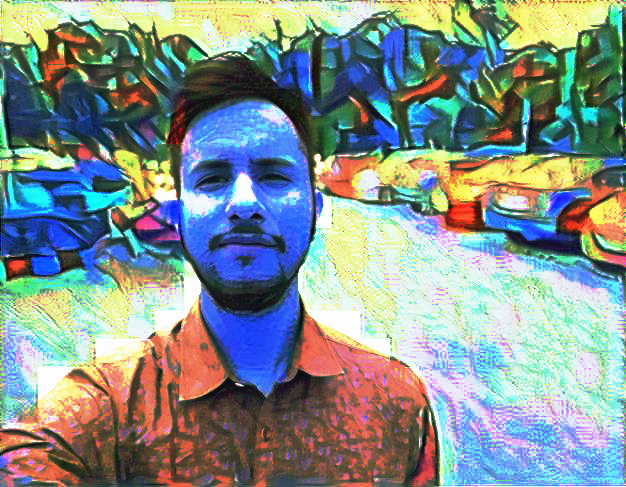

In [196]:
from __future__ import print_function
from __future__ import division
from __future__ import absolute_import

import argparse
import os
import numpy as np
from scipy.interpolate import interp1d
from scipy.misc import imread, imresize, imsave, fromimage, toimage


# Util function to match histograms
def match_histograms(source, template):
        

    oldshape = source.shape
    source = source.ravel()
    template = template.ravel()

    s_values, bin_idx, s_counts = np.unique(source, return_inverse=True,
                                            return_counts=True)
    t_values, t_counts = np.unique(template, return_counts=True)

    
    s_quantiles = np.cumsum(s_counts).astype(np.float64)
    s_quantiles /= s_quantiles[-1]
    t_quantiles = np.cumsum(t_counts).astype(np.float64)
    t_quantiles /= t_quantiles[-1]

    
    interp_t_values = np.interp(s_quantiles, t_quantiles, t_values)

    return interp_t_values[bin_idx].reshape(oldshape)

  
def original_color_transform(content, generated, mask=None, hist_match=0, mode='YCbCr'):
    generated = fromimage(toimage(generated, mode='RGB'), mode=mode)  
    if mask is None:
        if hist_match == 1:
            for channel in range(3):
                generated[:, :, channel] = match_histograms(generated[:, :, channel], content[:, :, channel])
        else:
            generated[:, :, 1:] = content[:, :, 1:]
    else:
        width, height, channels = generated.shape

        for i in range(width):
            for j in range(height):
                if mask[i, j] == 1:
                    if hist_match == 1:
                        for channel in range(3):
                            generated[i, j, channel] = match_histograms(generated[i, j, channel], content[i, j, channel])
                    else:
                        generated[i, j, 1:] = content[i, j, 1:]

    generated = fromimage(toimage(generated, mode=mode), mode='RGB') 
    return generated



def load_mask(mask_path, shape):
    mask = imread(mask_path, mode="L") 
    width, height, _ = shape
    mask = imresize(mask, (width, height), interp='bicubic').astype('float32')

    
    mask[mask <= 127] = 0
    mask[mask > 128] = 255

    mask /= 255
    mask = mask.astype(np.int32)

    return mask


hist_match=1
if hist_match == 1:
    image_suffix = "_histogram_color.png"
    mode = "RGB"
else:
    image_suffix = "_original_color.png"
    mode = "YCbCr"


generated_image = imread("generated_image.jpg")
img_width, img_height, _ = generated_image.shape

content_image =  imread("n.jpeg")
content_image = imresize(content_image, (img_width, img_height), interp='bicubic')

mask_transfer = 0
if mask_transfer:
    mask_img = load_mask(args.mask, generated_image.shape)
else:
    mask_img = None

img = original_color_transform(content_image, generated_image, mask_img, hist_match, mode=mode)
cv2_imshow(img)



